In [2]:
import mlflow
import pandas as pd
import seaborn as sns
import numpy as np
import torch
from nn_model import MyNeuralNet
from skorch import NeuralNetRegressor  # type: ignore
from skorch.callbacks import MlflowLogger
from utils import DATA_PATH, aggregate_replicates
from ETL import INCLUDED_FEATURES
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

# Fitness modeling

To propose candidate mutants, I first build a machine learning model of the fitness landscape.

Using the experimental testbed below, I converged on the following decently performant model/featurization. See final bar plot for out-of-fold performance and variance. 

## Training data

To test our model's ability to generalize on unseen mutants it's important to combine replicates so identical sequences don't end up in both train and test data. I took the average of `Pred_affinity` among replicates. I also filled NA-valued replicates with the max `Pred_affinity`. 

*Note:* [Li et al.](https://www.biorxiv.org/content/10.1101/2022.10.07.502662v1.full.pdf) (the follow-up paper on this dataset from the same lab) used an ensemble of either dropping NAs or filling with median affinity. I honestly don't understand why either of these approaches would be appropriate. Dropping NAs might be fine to focus on learning functional regions of the fitness landscape, but only in the context of an ensemble; otherwise the model may have trouble rejecting broken mutants. Filling NAs with median affinity seems plain wrong, as NA affinity indicates *very low* affinity, not median affinity. 

## Featurization

 I tested both one-hot encodings of the CDRs, and FAIR-ESM-2 embeddings of the full chains. The ESM embeddings performed slightly better. The ESM authors suggest doing a reduction using PCA, but I skipped this step for now. This would be an important next step in generating models with a lesser curse of dimensionality. 

## Model: Ridge Regression with RBF kernel. 

This is a decent prototype model that's non-linear but also not over-parametrized. Also, these models tend to do better at extrapolation than tree-based methods (a key requirement here). Specifically, RBF kernels tend toward a prediction of zero mean when when from the training data, so this model has a built-in "conservative" bias (radically new sequences will be predicted to have low affinity) that will work hand in hand with the trust-radius idea proposed by Biswas in the later Candidate Generation notebook.

I first got the model to memorize the input data, and then increased regularization manually until out-of-fold performance more-or-less peaked. Next steps would be to refine hyperparams automatically using Optuna or a tighter grid search. 

Test performance of this model using k-fold cross validation (where k=5) is summarized in the final bar plot below. Note that variance is fairly low across folds (error bars).

## Other future work

I only train a model on the heavy chain AAYL49. Future work would be to independently train on the light chain AAYL50, as done in Li et al.

This model shows only ok performance (spearman correlation ~.25). This is enough for the purposes of this exercise, but I'd like to see something above .5 (at least) for use in a real-world setting. 

Additionally, the inerrant noisiness of the data and desire to have uncertainty estimates on predictions suggests a a Gaussian process regression could be ideal for this task. GPR is famously expensive to train on large datasets. That said, the ESM2 quickstart notebooks suggested (encouragingly) using PCA to reduce the dimensionality of the embeddings while still maintaining reasonable performance. 

In [ ]:
LIBRARY = "AAYL49"
FILL_NA_AFFINITY_VALUE = 'max'
# FILL_NA_AFFINITY_VALUE = 'drop'

feature_types = ['one_hot', 'esm_emb']
FEATURE_TYPE = feature_types[1]
models = ['lr', 'rr-rbf', 'nn']
MODEL = models[1] 

with mlflow.start_run(experiment_id='466801391116261320'):
    mlflow.log_param('Model', MODEL)
    mlflow.log_param('Library', LIBRARY)
    mlflow.log_param('Feature type', FEATURE_TYPE)
    match FEATURE_TYPE:
        case 'one_hot':
            df = pd.read_parquet(f"{DATA_PATH}/{LIBRARY}_expanded.parquet")
        case 'esm_emb':
            df = pd.read_parquet(f"{DATA_PATH}/{LIBRARY}_emb_esm2.parquet")
    mlflow.log_param('Null Pred_affinity fill value', FILL_NA_AFFINITY_VALUE)
    df = aggregate_replicates(df, fillna=FILL_NA_AFFINITY_VALUE)   # type: ignore 

    feature_cols = df.columns[df.columns.isin(INCLUDED_FEATURES)==False]
    features_df = df[feature_cols]
    targets = df['Pred_affinity'].values
    match FEATURE_TYPE:
        case 'one_hot':
            enc = OneHotEncoder()
            one_hot_df = enc.fit_transform(features_df).todense()
            assert one_hot_df.shape[1] == features_df.columns.shape[0] * 20 
            features = np.asarray(one_hot_df)
        case 'esm_emb':
            features = features_df.values
    # Shuffle to remove any ordering 
    # TODO: stratify by # of mutations
    kf = KFold(shuffle=True, n_splits=5)
    mlflow.sklearn.autolog()
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        train_features = features[train_index].astype(np.float32)  # type: ignore 
        test_features = features[test_index].astype(np.float32)  # type: ignore 
        train_targets = targets[train_index].astype(np.float32)  # type: ignore 
        test_targets = targets[test_index].astype(np.float32)  # type: ignore 
        match MODEL:
            case 'lr':
                model = LinearRegression()
            case 'rr-rbf':
                model = KernelRidge(kernel='rbf', alpha=.01, gamma=3)  # type: ignore 
            case 'nn':
                device = "cuda" if torch.cuda.is_available() else "cpu"  # type: ignore 
                print(f"Using {device} device")
                train_targets = train_targets.reshape(-1,1)
                test_targets = test_targets.reshape(-1,1)
                max_epochs = 1000
                mlflow.log_param('Max epochs', max_epochs)
                model = NeuralNetRegressor(
                    MyNeuralNet(input_width=features.shape[1]),  # type: ignore 
                    max_epochs=max_epochs,
                    lr=0.1,
                    # Shuffle training data on each epoch
                    iterator_train__shuffle=True,
                    callbacks=[MlflowLogger()],
                    device = device,
                    optimizer=torch.optim.AdamW
                )
            case _:
                raise ValueError()
        model.fit(X=train_features, y=train_targets)
        y_hat = model.predict(test_features)
        mlflow.log_metric(f'test_r2', r2_score(test_targets, y_hat))  # type: ignore 
        mlflow.log_metric(f'test_mse', mean_squared_error(test_targets, y_hat))  # type: ignore 
        mlflow.log_metric(f'spearmanr', spearmanr(test_targets, y_hat)[0])  # type: ignore 
        print(i)

<AxesSubplot: xlabel='key', ylabel='value'>

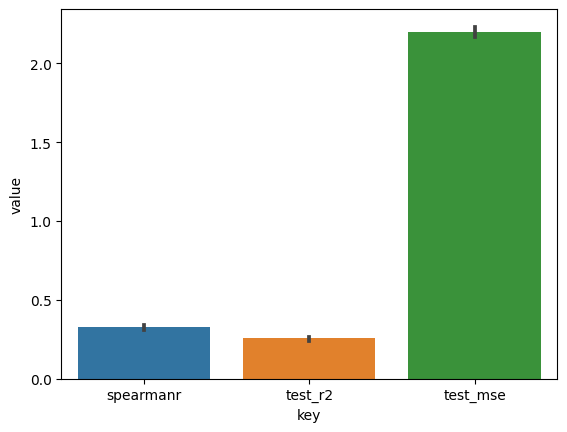

In [11]:
# model performance metric for best model saved from mlflow.
m = pd.read_csv("./data/metrics.csv")
sns.barplot(data=m, x='key', y='value')